In [1]:
import torch
import clip
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics
from ClipAdapter.dataset import CoCoDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import numpy as np
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
img_path = "/CV/gaobiaoli/dataset/CIS-Dataset"
anno_path = "/CV/gaobiaoli/dataset/CIS-Dataset/dataset/annotations"
CIStoken = [
        "a photo of precast component",
        "a photo of a precast component delivery truck",
        "a photo of a bulldozer",
        "a photo of a dump truck",
        "a photo of an excavator",
        "a photo of a concrete mixer",
        "a photo of a person wearing safety helmet correctly",
        "a photo of a person who do not wear safety helmet correctly",
        "a photo of a road roller",
        "a photo of a wheel loader",
    ]
device = "cuda:1"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

coco_json_test = os.path.join(anno_path, "test.json")
imgs_path_test = os.path.join(img_path, "test")
dataset_test = CoCoDataset(
    coco_json=coco_json_test,
    imgs_path=imgs_path_test,
    transform=preprocess,
    category_init_id=0,
)
dataloader_test = DataLoader(dataset=dataset_test, num_workers=4, batch_size=32)
all_labels = []
all_features = []
with torch.no_grad():
    for i, (imgs, label, _) in enumerate(tqdm(dataloader_test)):
        imgs = imgs.to(device)
        image_features = clip_model.encode_image(imgs)
        image_features_norm = image_features / image_features.norm(
            dim=-1, keepdim=True
        )
        
        all_labels.extend(label.cpu().numpy())
        all_features.extend(image_features_norm.cpu().numpy())



loading annotations into memory...
Done (t=2.37s)
creating index...
index created!


100%|██████████| 1200/1200 [06:36<00:00,  3.02it/s]


In [14]:
Y = np.vstack(all_labels)
X = np.vstack(all_features)
digits_final = TSNE(perplexity=30).fit_transform(X) 


(<Figure size 800x800 with 1 Axes>, <Axes: >)

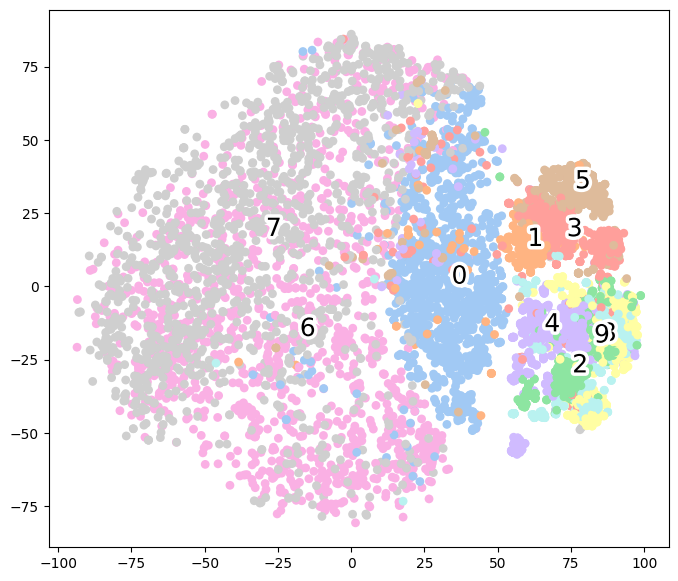

In [48]:
def plot(x, colors):
    # Choosing color palette
    # https://seaborn.pydata.org/generated/seaborn.color_palette.html
    palette = np.array(sns.color_palette("pastel", 10))
    # pastel, husl, and so on

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int8)])
    # Add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=18)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    plt.savefig('./digits_tsne-pastel.png', dpi=120)
    return f, ax

def sampleFilter(X,Y,num_class,max=10):
    count=[0 for _ in range(num_class)]
    n_X=[]
    n_Y=[]
    for i in range(len(X)):
        if count[Y[i].item()]<max:
            n_X.append(X[i])
            n_Y.append(Y[i])
            count[Y[i].item()]+=1
    return np.vstack(n_X),np.vstack(n_Y)


n_X,n_Y=sampleFilter(digits_final, Y,num_class=10,max=1280)
plot(n_X,n_Y[:,0])

